## Toxic comments analysis

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import string
import scipy
import keras
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


Using TensorFlow backend.


### Read data

In [96]:
train_df = pd.read_csv('data/train.csv')

In [97]:
# Split to input and output
X_train = train_df['comment_text']
y_train = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [98]:
# Split train data to train and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [99]:
print('Train data:', X_train.shape)
print('Validation data:', X_val.shape)\

Train data: (143613,)
Validation data: (15958,)


### Check the data

In [6]:
# Comment examples
X_train[:5].values

array(["Outrageous!!!!! \n\nThis block is outrageous and un-Wiki! Lauren Caitlin is about a TRILLION times more important, beloved and prominent than at least 99% of all the article subjects on this joke of a site.\n\nWHY, OH WHY, are Wikipedia's administrators so freaking a***-retentive and have such an inferiority complex and fragile egos???\n\nDo all of you HAVE TO ruin the fun and enthusiasm of the rest of us members JUST BECAUSE you need to feel powerful and important so desperately?? Are all of you school marm librarian types in wool sweaters with thick glasses, afraid of the thought of romance and fun?\n\nSHEESH.\n\nThis Lauren Caitlin Upton Bio page better be approved quickly and available for work. America can't wait any longer for the Wikipedia Administrator Moron Club and assorted other freak Wikipedia unions to get a life.\n\nDon't you people have JOBS, or do you just play with yourselves here while you're playing with and tormenting the rest of us contributors?",
       "E

In [7]:
# Classes statistics
y_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,143613.000000,143613.000000,143613.000000,143613.000000,143613.000000,143613.000000
mean,0.096189,0.010076,0.053011,0.003071,0.049341,0.008760
std,0.294851,0.099871,0.224055,0.055329,0.216580,0.093183
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Text(0.5, 0, 'Toxicity classes')

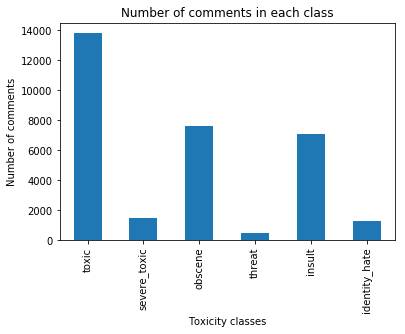

In [8]:
y_train.sum().plot.bar(title='Number of comments in each class')
plt.ylabel('Number of comments')
plt.xlabel('Toxicity classes')

In [9]:
# Check the lengths of the comments
lengths_list = pd.Series([len(x) for x in X_train])
lengths_list.describe()

count    143613.000000
mean        395.598156
std         593.677505
min           6.000000
25%          96.000000
50%         205.000000
75%         437.000000
max        5000.000000
dtype: float64

Text(0, 0.5, 'Number of comments')

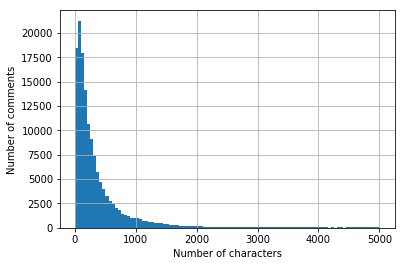

In [10]:
lengths_list.hist(bins=100)
plt.xlabel("Number of characters")
plt.ylabel("Number of comments")

Notes:
Need text cleaning, Imbalanced data, <10% are toxic


### Clean data

In [100]:
def clean_comments(df):

    # Lowercase
    df_clean = df.str.lower()

    # Change empty space characters to spaces
    df_clean = df_clean.str.replace(r'\s', ' ', regex=True)

    # Remove non ASCII letters
    df_clean = df_clean.str.replace(r"[^a-z ']+", '', regex=True)

    # Normalize spaces (for readability)
    df_clean = pd.Series([" ".join(x.split()) for x in df_clean])
    
    return df_clean
    
X_train_clean = clean_comments(X_train)    
X_train_clean[:5].values

array(["outrageous this block is outrageous and unwiki lauren caitlin is about a trillion times more important beloved and prominent than at least of all the article subjects on this joke of a site why oh why are wikipedia's administrators so freaking aretentive and have such an inferiority complex and fragile egos do all of you have to ruin the fun and enthusiasm of the rest of us members just because you need to feel powerful and important so desperately are all of you school marm librarian types in wool sweaters with thick glasses afraid of the thought of romance and fun sheesh this lauren caitlin upton bio page better be approved quickly and available for work america can't wait any longer for the wikipedia administrator moron club and assorted other freak wikipedia unions to get a life don't you people have jobs or do you just play with yourselves here while you're playing with and tormenting the rest of us contributors",
       "except that you would never dare say something in n

### Analyze words

In [101]:
# Bag of words
cv = CountVectorizer(stop_words='english', binary=True)
X_train_vec = cv.fit_transform(X_train_clean)

In [102]:
word_freq = zip(cv.get_feature_names(), np.asarray(X_train_vec.sum(axis=0))[0])    
word_freq = sorted(word_freq, key=lambda x: -x[1])

In [103]:
# Top 20 most frequent words
word_freq[:20]

[('article', 28667),
 ('page', 24735),
 ('talk', 20895),
 ('wikipedia', 20663),
 ('just', 19828),
 ('like', 18906),
 ('don', 16349),
 ('think', 14388),
 ('know', 13351),
 ('people', 11722),
 ('edit', 11688),
 ('time', 11183),
 ('did', 10792),
 ('thanks', 10673),
 ('articles', 10089),
 ('make', 9831),
 ('use', 9577),
 ('good', 9503),
 ('does', 8967),
 ('want', 8850)]

### Vectorize text

In [139]:
tfidf = TfidfVectorizer(stop_words='english')
X_train_vec = tfidf.fit_transform(X_train)

In [140]:
lsa = TruncatedSVD(n_components=100)
X_train_lsa = lsa.fit_transform(X_train_vec)
#x_train_lsa = Normalizer(copy =False).fit_transform(X_train_lsa)
X_train_lsa.shape

(143613, 100)

### Prepare validation dataset

In [141]:
X_val_vec = tfidf.transform(X_val)
X_val_lsa = lsa.transform(X_val_vec)

### Build model

In [142]:
def create_model(dropout=0., l1_dim=32, lsa_dim=100):
    model = Sequential()
    model.add(Dense(l1_dim, input_dim=lsa_dim, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(6, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

keras_estimator = KerasClassifier(build_fn=create_model, verbose=1)

In [143]:
model = create_model()

In [144]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 32)                3232      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 6)                 198       
Total params: 3,430
Trainable params: 3,430
Non-trainable params: 0
_________________________________________________________________


In [145]:
hist = model.fit(X_train_lsa, y_train.values, epochs=20)

Train on 143613 samples
Epoch 1/20
143613/143613 [==============================] - 5s 36us/sample - loss: 0.1025 - accuracy: 0.9713
Epoch 2/20
143613/143613 [==============================] - 5s 34us/sample - loss: 0.0688 - accuracy: 0.9776s - los
Epoch 3/20
143613/143613 [==============================] - 5s 33us/sample - loss: 0.0657 - accuracy: 0.9783
Epoch 4/20
143613/143613 [==============================] - 5s 33us/sample - loss: 0.0640 - accuracy: 0.9785
Epoch 5/20
143613/143613 [==============================] - 5s 33us/sample - loss: 0.0629 - accuracy: 0.9788
Epoch 6/20
143613/143613 [==============================] - 5s 33us/sample - loss: 0.0622 - accuracy: 0.9789
Epoch 7/20
143613/143613 [==============================] - 5s 33us/sample - loss: 0.0616 - accuracy: 0.9789
Epoch 8/20
143613/143613 [==============================] - ETA: 0s - loss: 0.0612 - accuracy: 0.97 - 5s 33us/sample - loss: 0.0612 - accuracy: 0.9791
Epoch 9/20
143613/143613 [=============================

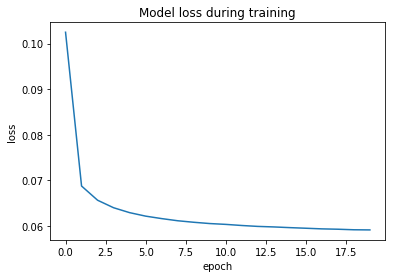

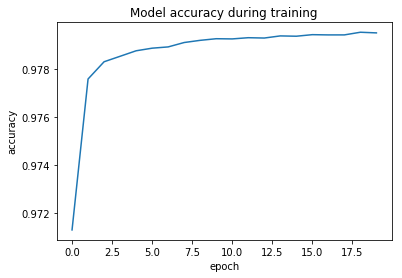

In [146]:
# Plot training
# Loss
plt.plot(hist.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('Model loss during training')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Accuracy
plt.plot(hist.history['accuracy'])
#plt.plot(history.history['val_acc'])
plt.title('Model accuracy during training')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [147]:
val_loss, val_acc = model.evaluate(X_val_lsa,  y_val.values, verbose=2)
val_acc

15958/1 - 0s - loss: 0.0558 - accuracy: 0.9792


0.9791954

In [148]:
def eval_auc(y, pred):
    auc_list = []
    for i in range(6):
    
        fpr, tpr, _ = sklearn.metrics.roc_curve(y.iloc[:, i].values, pred[:, i])
        auc_list.append(sklearn.metrics.auc(fpr, tpr))
    
    print('AUC for each class:')
    print(np.array(auc_list))
    print('Mean AUC:', np.mean(auc_list))

In [149]:
pred_val = model.predict(X_val_lsa)
eval_auc(y_val, pred_val)

AUC for each class:
[0.94965598 0.97824953 0.97218706 0.96782424 0.96305315 0.94215106]
Mean AUC: 0.962186833753231


### Build sklearn pipeline and tune hyperparameters

In [78]:
train_df = pd.read_csv('data/train.csv')

In [79]:
X_train = train_df['comment_text']
y_train = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [80]:
X_train_clean = clean_comments(X_train)

In [81]:
pipeline_estimator = Pipeline([('tfidf', TfidfVectorizer(analyzer ='word', max_features=2500, stop_words='english')), 
                       ('lsa', TruncatedSVD(n_components=10)), 
                       ('nn', keras_estimator)])

In [94]:

param_grid = [
    {
        'nn__dropout': [0.5, 0.3, 0.],
        'nn__l1_dim': [10, 20, 30, 50],
        'nn__batch_size':[8, 16, 32],
        'lsa__n_components': [5],
        'nn__lsa_dim': [5],
        'tfidf__use_idf': [True, False],
        'tfidf__ngram_range': [(1,1), (1,2), (2,2), (1,3)]
    }, 
    {
        'nn__dropout': [0.5, 0.3, 0.],
        'nn__l1_dim': [10, 20, 30, 50],
        'nn__batch_size':[8, 16, 32],
        'lsa__n_components': [10],
        'nn__lsa_dim': [10],
        'tfidf__use_idf': [True, False],
        'tfidf__ngram_range': [(1,1), (1,2), (2,2), (1,3)]
    },
    {
        'nn__dropout': [0.5, 0.3, 0.],
        'nn__l1_dim': [10, 20, 30, 50],
        'nn__batch_size':[8, 16, 32],
        'lsa__n_components': [20],
        'nn__lsa_dim': [20],
        'tfidf__use_idf': [True, False],
        'tfidf__ngram_range': [(1,1), (1,2), (2,2), (1,3)]
    },
    {
        'nn__dropout': [0.5, 0.3, 0.],
        'nn__l1_dim': [10, 20, 30, 50],
        'nn__batch_size':[8, 16, 32],
        'lsa__n_components': [40],
        'nn__lsa_dim': [40],
        'tfidf__use_idf': [True, False],
        'tfidf__ngram_range': [(1,1), (1,2), (2,2), (1,3)]
    },
    {
        'nn__dropout': [0.5, 0.3, 0.],
        'nn__l1_dim': [10, 20, 30, 50],
        'nn__batch_size':[8, 16, 32],
        'lsa__n_components': [100],
        'nn__lsa_dim': [100],
        'tfidf__use_idf': [True, False],
        'tfidf__ngram_range': [(1,1), (1,2), (2,2), (1,3)]
    }]

    
    
kfold_splits = 5
grid = GridSearchCV(estimator=pipeline_estimator,  
                    n_jobs=-1, 
                    verbose=1,
                    return_train_score=True,
                    cv=kfold_splits,
                    param_grid=param_grid,)


In [95]:
grid_result = grid.fit(X_train_clean, y_train) #callbacks=[tbCallBack]

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 1440 candidates, totalling 7200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  35 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  39 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  43 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  44 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed: 11

BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

### Checking performance on test data

In [91]:
# Read data
X_test = pd.read_csv('data/test.csv')
y_test = pd.read_csv('data/test_labels.csv')

X_test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [92]:
# Points with value of -1 were not used for evaluation
y_test.tail(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
153154,fffa8a11c4378854,0,0,0,0,0,0
153155,fffac2a094c8e0e2,1,0,1,0,1,0
153156,fffb5451268fb5ba,0,0,0,0,0,0
153157,fffc2b34bbe61c8d,-1,-1,-1,-1,-1,-1
153158,fffc489742ffe69b,-1,-1,-1,-1,-1,-1
153159,fffcd0960ee309b5,-1,-1,-1,-1,-1,-1
153160,fffd7a9a6eb32c16,-1,-1,-1,-1,-1,-1
153161,fffda9e8d6fafa9e,-1,-1,-1,-1,-1,-1
153162,fffe8f1340a79fc2,-1,-1,-1,-1,-1,-1
153163,ffffce3fb183ee80,-1,-1,-1,-1,-1,-1


In [93]:
# join comments with labels and remove rows where labels are '-1'
test_df = X_test.merge(y_test, on='id')
test_df_filtered = test_df[test_df['toxic'] != -1]
test_df_filtered.shape

(63978, 8)

In [94]:
X_test_filtered = test_df_filtered['comment_text']
y_test_filtered = test_df_filtered[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]

In [95]:
# Clean text
X_test_clean = clean_comments(X_test_filtered)
# Vectorize text
X_test_vec = tfidf.transform(X_test_clean)
# LSA - to deduce dimentionality
X_test_lsa = lsa.transform(X_test_vec)
# Classify with neural network
pred_test = model.predict(X_test_lsa)

In [96]:
# Evaluate
eval_auc(y_test_filtered, pred_test)

AUC for each class:
[0.85275197 0.96236014 0.89073293 0.89305407 0.87436867 0.89348917]
Mean AUC: 0.8944594932663849


In [ ]:
## TODO: Go from start and anotate, comment everything
# check on test, and put test checking to the end of file
# add hyper parameter tuning, leave over night
# print training
# Do we need to add class weights for multilabel classification

# Stage 2: once have good results - put to aws